In [56]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from numpy import load
import time
import sys
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy
import math
from numpy import loadtxt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, BatchNormalization, MaxPool2D, MaxPooling2D, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [ ]:

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 4 x 4

In [ ]:
def get_data(test_data_size,seed):
    mat = scipy.io.loadmat('ADP_BS1_Nt4_Nc4_BW100MHz_yaxis.mat')
    ADP = mat['ADP']
    loc = mat['L']
    ADP = np.reshape(ADP,[4,4,1,72400])
    ADPt = np.transpose(ADP,(3,1,0,2))
    loct = np.transpose(loc,(1,0))
    train_ADP, test_ADP, train_Loc, test_Loc = train_test_split(ADPt,loct, test_size=test_data_size, random_state=seed)

    return train_ADP, test_ADP, train_Loc, test_Loc
def train4(train_ADP, train_Loc, test_data):
  ## Neural Network Artitechture and Training for training on 32x32 input
  with tf.device("gpu:0"):
      NN_model = Sequential()
# The Input Layer :
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal',input_shape = (4,4,1), activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

# The Hidden Layers :
      NN_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
  # The Output Layer :
      NN_model.add(Flatten())
      NN_model.add(Dense(3))
  # Compile the network :
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
      NN_model.summary()
      checkpoint_name = 'ADP4x4_weights_100MHz/ADP4_weights_test_'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
     # checkpoint_name = 'ADP4_weights_test_'+str(seed)+'seed_'+str(test_data)+'p/Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
      checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

      callbacks_list = [checkpoint]
      history = NN_model.fit(train_ADP, train_Loc, epochs=300, batch_size=100, validation_split = 0.1, callbacks=callbacks_list)
  return history

In [ ]:
def test(test_ADP, test_Loc, file_name):
  model = tf.keras.models.load_model(file_name)
  y_hat = model.predict(test_ADP)
  y_hat = y_hat[:,0:2]
  y_true = test_Loc[:,0:2]
  MSE = np.square(np.subtract(y_true,y_hat)).mean()
  RMSE = np.sqrt(MSE)
 

  return RMSE

## Train and Test

In [ ]:
test_data = 0.1
seed = 1
train_ADP, test_ADP, train_Loc, test_Loc  = get_data(test_data,seed)
train8(train_ADP, train_Loc,test_data)
file_name ='ADP4x4_weights_100MHz/ADP4_weights_test_'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
RMSE = test(test_ADP, test_Loc,file_name)

## k-fold

In [ ]:
# k-Fold Train 
'''
import timeit
k = 5 # number of folds
seed_ind = np.linspace(1,k,k,dtype = int,endpoint= True)
start = timeit.timeit()


for seed in seed_ind:
 
  test_data = 0.50
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train4(train_ADP, train_Loc,test_data,seed)

  test_data = 0.20
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train4(train_ADP, train_Loc,test_data,seed)
 
  test_data = 0.99
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train4(train_ADP, train_Loc,test_data,seed)

  test_data = 0.995
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train84(train_ADP, train_Loc,test_data,seed)

  test_data = 0.9975
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train84(train_ADP, train_Loc,test_data,seed)

  test_data = 0.999
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train4(train_ADP, train_Loc,test_data,seed)


end = timeit.timeit()
print(end - start)'''

In [ ]:
# k - fold test
'''
k = 5
RMSE = np.empty(shape=(6,k))
seed_ind = np.linspace(1,k,k, dtype = int,endpoint= True)

for seed in seed_ind:
  
  print(seed)

  test_data = 0.50
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[0,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.20
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[1,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.99
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[2,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.995
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[3,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.9975
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[4,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.999
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[5,seed-1] = test(test_ADP, test_Loc, checkpoint_name)



print(np.mean(RMSE,1))
print(np.std(RMSE,1))
'''

# 8 x 8

In [ ]:

## Data Preparation to feed the CNN trainingi
def get_data(test_data_size,seed):
    mat = scipy.io.loadmat('ADP_BS1_Nt8_Nc8_BW100MHz_yaxis.mat')
    ADP = mat['ADP']
    loc = mat['L']
    ADP = np.reshape(ADP,[8,8,1,72400])
    ADPt = np.transpose(ADP,(3,1,0,2))
    loct = np.transpose(loc,(1,0))
    train_ADP, test_ADP, train_Loc, test_Loc = train_test_split(ADPt,loct, test_size=test_data_size, random_state=seed)

    return train_ADP, test_ADP, train_Loc, test_Loc
def train8(train_ADP, train_Loc, test_data):
  ## Neural Network Artitechture and Training for training on 32x32 input
  with tf.device("gpu:0"):
      NN_model = Sequential()
# The Input Layer :
      NN_model.add(Conv2D(16,(7,7), padding='same', kernel_initializer='normal',input_shape = (8,8,1), activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

# The Hidden Layers :
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
  # The Output Layer :
      NN_model.add(Flatten())
      NN_model.add(Dense(3))
  # Compile the network :
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
      NN_model.summary()
      checkpoint_name =  'ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
      checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

      callbacks_list = [checkpoint]
      history = NN_model.fit(train_ADP, train_Loc, epochs=1000, batch_size=100, validation_split = 0.1, callbacks=callbacks_list)
  return history

In [ ]:

def test(test_ADP, test_Loc, file_name):
  model = tf.keras.models.load_model(file_name)
  y_hat = model.predict(test_ADP)
  y_hat = y_hat[:,0:2]
  y_true = test_Loc[:,0:2]
  MSE = np.square(np.subtract(y_true,y_hat)).mean()
  RMSE = np.sqrt(MSE)
 

  return RMSE

## Train and Test

In [ ]:
test_data = 0.1
seed = 1
train_ADP, test_ADP, train_Loc, test_Loc  = get_data(test_data,seed)
train8(train_ADP, train_Loc,test_data)
file_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
RMSE = test(test_ADP, test_Loc,file_name)

## k-fold

In [ ]:
# k-Fold Train 
'''
import timeit
k = 5 # number of folds
seed_ind = np.linspace(1,k,k,dtype = int,endpoint= True)
start = timeit.timeit()


for seed in seed_ind:
 
  test_data = 0.50
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)

  test_data = 0.20
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)
 
  test_data = 0.99
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)

  test_data = 0.995
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)

  test_data = 0.9975
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)

  test_data = 0.999
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train8(train_ADP, train_Loc,test_data,seed)


end = timeit.timeit()
print(end - start)'''

In [ ]:
# k -fold test
'''
k = 5
RMSE = np.empty(shape=(6,k))
seed_ind = np.linspace(1,k,k, dtype = int,endpoint= True)

for seed in seed_ind:
  
  print(seed)

  test_data = 0.50
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[0,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.20
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[1,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.99
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[2,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.995
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[3,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.9975
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[4,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.999
  checkpoint_name ='ADP8x8_weights_100MHz_seed42/ADP8_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[5,seed-1] = test(test_ADP, test_Loc, checkpoint_name)



print(np.mean(RMSE,1))
print(np.std(RMSE,1))
'''

# 16 x 16

In [ ]:

## Data Preparation to feed the CNN trainingi
def get_data(test_data_size,seed):
    mat = scipy.io.loadmat('ADP_BS1_Nt16_Nc16_BW100MHz_yaxis_rev1.mat')
    ADP = mat['ADP']
    loc = mat['L']
    ADP = np.reshape(ADP,[16,16,1,72400])
    ADPt = np.transpose(ADP,(3,1,0,2))
    loct = np.transpose(loc,(1,0))
    index = np.arange(72400)+1
    train_ADP, test_ADP, train_Loc, test_Loc, train_index, test_index = train_test_split(ADPt,loct, index, test_size=test_data_size, random_state=seed)
    return train_ADP, test_ADP, train_Loc, test_Loc,train_index
def train16(train_ADP, train_Loc, test_data):
  ## Neural Network Artitechture and Training for training on 32x32 input
  with tf.device("gpu:0"):
      NN_model = Sequential()
# The Input Layer :
      NN_model.add(Conv2D(8, (8,8), padding='same', kernel_initializer='normal',input_shape = (16,16,1), activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

# The Hidden Layers :
      NN_model.add(Conv2D(16, (7,7), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
  # The Output Layer :
      NN_model.add(Flatten())
      NN_model.add(Dense(3))
  # Compile the network :
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
      NN_model.summary()
      checkpoint_name =  'ADP16x16_weights_100MHz/ADP16_BS1_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
      checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

      callbacks_list = [checkpoint]
      NN_model.fit(train_ADP, train_Loc, epochs=1000, batch_size=100, validation_split = 0.1, callbacks=callbacks_list)
  return checkpoint

In [ ]:
def test(test_ADP, test_Loc, file_name):
  model = tf.keras.models.load_model(file_name)
  y_hat = model.predict(test_ADP)
  y_hat = y_hat[:,0:2]
  y_true = test_Loc[:,0:2]
  MSE = np.square(np.subtract(y_true,y_hat)).mean()
  RMSE = np.sqrt(MSE)

## Train and Test

In [ ]:
# One sample
seed = 1
test_data = 0.1
train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
history = train16(train_ADP, train_Loc,test_data,seed)
checkpoint_name = 'ADP16x16_weights_100MHz/ADP16_BS1_weights_test_'+str(seed)+'_seed_'+str(test_data)+'p.hdf5'
RMSE = test(test_ADP, test_Loc,  checkpoint_name)

## k-fold

# 32 x 32

In [32]:


## Data Preparation to feed the CNN trainingi
def get_data(test_data_size,seed):
    mat = scipy.io.loadmat('ADP_BS1_Nt32_Nc32_BW100MHz_yaxis.mat')
    ADP = mat['ADP']
    loc = mat['L']
    ADP = np.reshape(ADP,[32,32,1,72400])
    ADPt = np.transpose(ADP,(3,1,0,2))
    loct = np.transpose(loc,(1,0))
    train_ADP, test_ADP, train_Loc, test_Loc = train_test_split(ADPt,loct, test_size=test_data_size, random_state=seed)

    return train_ADP, test_ADP, train_Loc, test_Loc




In [46]:

def train32(train_ADP, train_Loc, test_data,seed):
  ## Neural Network Artitechture and Training for training on 32x32 input
  with tf.device("gpu:0"):
      NN_model = Sequential()
# The Input Layer :
      NN_model.add(Conv2D(4, (16,16), padding='same', kernel_initializer='normal',input_shape = (32,32,1), activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

# The Hidden Layers :
      NN_model.add(Conv2D(8, (8,8), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(16, (7,7), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
  # The Output Layer :
      NN_model.add(Flatten())
      NN_model.add(Dense(3))
  # Compile the network :
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
      NN_model.summary()
      checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
      callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, mode='min', verbose=1),
        keras.callbacks.ModelCheckpoint(
            checkpoint_name,
            monitor='val_loss', save_best_only=True,  verbose=1)
        ]
      history = NN_model.fit(train_ADP, train_Loc, epochs=300, batch_size=32, validation_split = 0.1, callbacks=callbacks_list)
  return history

In [ ]:

def test(test_ADP, test_Loc, file_name):
  model = tf.keras.models.load_model(file_name)
  y_hat = model.predict(test_ADP)
  y_hat = y_hat[:,0:2]
  y_true = test_Loc[:,0:2]
  MSE = np.square(np.subtract(y_true,y_hat)).mean()
  RMSE = np.sqrt(MSE)
 

  return RMSE


 ## Train & Test

In [ ]:
seed = 1
test_data = 0.1
train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
history = train32(train_ADP, train_Loc,test_data,seed)
checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
RMSE = test(test_ADP, test_Loc,  checkpoint_name)
print(RMSE)

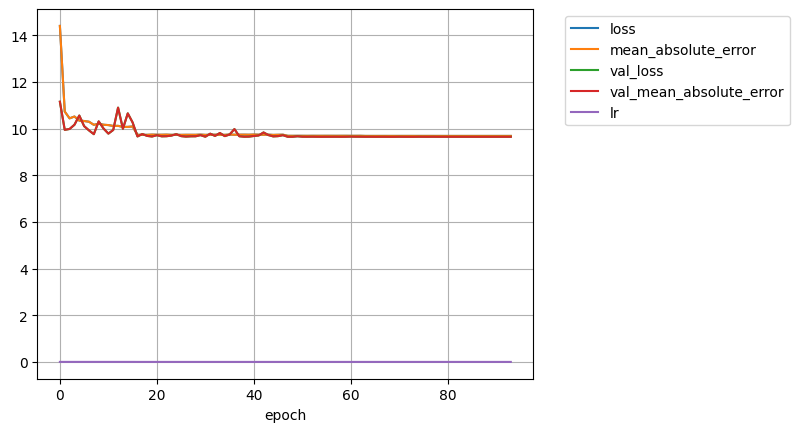

In [17]:

pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()

## k-fold

In [ ]:
# k-Fold train
'''
import timeit
k = 5
seed_ind = np.linspace(1,k,k,dtype = int,endpoint= True)
start = timeit.timeit()


for seed in seed_ind:
 
  test_data = 0.50
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)

  test_data = 0.20
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)
 
  test_data = 0.99
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)

  test_data = 0.995
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)

  test_data = 0.9975
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)

  test_data = 0.999
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train32(train_ADP, train_Loc,test_data,seed)


end = timeit.timeit()
print(end - start)'''

In [ ]:
# k -fold test
'''
k = 5
RMSE = np.empty(shape=(2,k))
seed_ind = np.linspace(1,k,k, dtype = int,endpoint= True)

for seed in seed_ind:
  
  print(seed)

  test_data = 0.50
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[0,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.20
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[1,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.99
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[2,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.995
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[3,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.9975
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[4,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.999
  checkpoint_name = 'ADP32_weights_CNN/ADP32_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[5,seed-1] = test(test_ADP, test_Loc, checkpoint_name)



print(np.mean(RMSE,1))
print(np.std(RMSE,1))
'''

# 64 x 64

In [31]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, BatchNormalization, MaxPool2D,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from numpy import load
import time
import sys
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Data Preparation to feed the CNN trainingi
def get_data(test_data_size,seed):
    with h5py.File('ADP_BS1_Nt64_Nc64_BW100MHz_O1_3p5_V2.mat', 'r') as file:
        # Get the data from a specific dataset 
        ADP = file['ADP'][:]
        loc = file['L'][:]
    ADP = np.reshape(ADP,[64,64,1,72400])
    ADPt = np.transpose(ADP,(3,1,0,2))
    loct = loc # np.transpose(loc,(1,0))
    
    train_ADP, test_ADP, train_Loc, test_Loc = train_test_split(ADPt,loct[:,0:2], test_size=test_data_size, random_state=seed)

    return train_ADP, test_ADP, train_Loc, test_Loc




In [29]:
seed = 10
test_data = 0.10
with h5py.File('ADP_BS1_Nt64_Nc64_BW100MHz_O1_3p5_V2.mat', 'r') as file:
    # Get the data from a specific dataset 
    ADP = file['ADP'][:]
    loc = file['L'][:]
ADP = np.reshape(ADP,[64,64,1,72400])
ADPt = np.transpose(ADP,(3,1,0,2))
loct = loc # np.transpose(loc,(1,0))

train_ADP, test_ADP, train_Loc, test_Loc = train_test_split(ADPt,loct[:,0:2], test_size=test_data, random_state=seed)

In [37]:

def train64_1(train_ADP, train_Loc, test_data,seed):
  ## Neural Network Artitechture and Training for training on 32x32 input
  with tf.device("gpu:0"):
      NN_model = Sequential()
# The Input Layer :
      NN_model.add(Conv2D(2, (32,32), padding='same', kernel_initializer='normal',input_shape = (64,64,1), activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

      NN_model.add(Conv2D(4, (16,16), padding='same', kernel_initializer='normal',activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))

# The Hidden Layers :
      NN_model.add(Conv2D(8, (8,8), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(16, (7,7), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
      NN_model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='normal', activation='relu'))
      NN_model.add(BatchNormalization())
      NN_model.add(MaxPool2D(pool_size=(2, 2)))
  # The Output Layer :
      NN_model.add(Flatten())
      NN_model.add(Dense(2))
  # Compile the network :
      NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
      NN_model.summary()
      checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
      callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, mode='min', verbose=1),
        keras.callbacks.ModelCheckpoint(
            checkpoint_name,
            monitor='val_loss', save_best_only=True,  verbose=1)
        ]
      history = NN_model.fit(train_ADP, train_Loc, epochs=300, batch_size=80, validation_split = 0.1, callbacks=callbacks_list)
  return history

## Train & Test

In [ ]:
seed = 10
test_data = 0.10
train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
history = train64_1(train_ADP, train_Loc,test_data,seed)
checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
RMSE = test(test_ADP, test_Loc,  checkpoint_name)


In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()

## k-fold

In [ ]:
# k fold Train
'''
import timeit

k = 1
RMSE = np.empty(shape=(6,k))
seed_ind = np.linspace(1,k,k, dtype = int,endpoint= True)
start = timeit.timeit()


for seed in seed_ind:
  test_data = 0.50
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)

  test_data = 0.10
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)

  test_data = 0.99
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)

  test_data = 0.995
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)

  test_data = 0.9975
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)

  test_data = 0.999
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  train64(train_ADP, train_Loc,test_data,seed)


end = timeit.timeit()
print(end - start)'''

In [ ]:
# k-fold test
'''
k = 5
RMSE = np.empty(shape=(6,k))
seed_ind = np.linspace(1,k,k, dtype = int,endpoint= True)

for seed in seed_ind:
  
  print(seed)
  test_data = 0.50
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[0,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.20
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[1,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.99
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[2,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.995
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[3,seed-1] = test(test_ADP, test_Loc,  checkpoint_name)

  test_data = 0.9975
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[4,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

  test_data = 0.999
  checkpoint_name = 'ADP64_weights_CNN/ADP64_weights_test'+str(seed)+'seed_'+str(test_data)+'p.hdf5'
  train_ADP, test_ADP, train_Loc, test_Loc = get_data(test_data,seed)
  RMSE[5,seed-1] = test(test_ADP, test_Loc, checkpoint_name)

print(np.mean(RMSE,1))
print(np.std(RMSE,1))
'''

